In [1]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
def sad(img_l: np.ndarray, img_r: np.ndarray, min_row: int, max_row: int, min_col: int, max_col: int , d: int) -> float:
    sad_val = 0.0
    sad_mat = np.abs(img_r[min_row : max_row, min_col:max_col] - img_l[min_row : max_row, min_col+d:max_col+d])
    sad_val = sum(sum(sad_mat))
    return sad_val

In [3]:
def semi_global(img_l: str, img_r: str, d_range: int, win: int, rl:bool):
    img_l = mpimg.imread(img_l)
    img_r = mpimg.imread(img_r)
    gray_l = img_l[:, :, 0] * 0.299 + img_l[:, :, 1] * 0.587 + img_l[:, :, 2] * 0.144
    gray_r = img_r[:, :, 0] * 0.299 + img_r[:, :, 1] * 0.587 + img_r[:, :, 2] * 0.144
    h,w = gray_l.shape
    c = list()
    disparity = np.zeros(gray_l.shape)

    # fitting costs
    for y in range(h):
        c.append(list())
        min_row = np.maximum(0,y-win)
        max_row = np.minimum(h, y+win+1)
        for x in range(w):
            c[y].append(list())
            min_col = np.maximum(0, x - win)
            max_col = np.minimum(w, x + win+1)
            if rl:
                d_min = 0                       # assume that there is no negative disparity
                d_max = np.minimum(d_range+1,w-max_col+1)
                
            else:
                d_min = np.maximum(-d_range,-min_col)
                d_max = 1 
            sads = np.zeros(d_max-d_min)
            #print(len(sads))
            for i in range(d_min,d_max):
                if rl:
                    block_id = i-d_min
                else:
                    block_id = -i+d_max-1
                sads[block_id] = sad(gray_l,gray_r, min_row,max_row,min_col,max_col,i)
            c[y][x]=list(sads)
            # best_match = np.argmin(sads)
    # Cost aggregation
    l = [[],[],[],[]]
    for y in range(h):
        l[0].append(list())
        l[1].append(list())
        l[2].append(list())
        l[3].append(list())
        for x in range(w):
            l[0][y].append(list())
            l[1][y].append(list())
            l[2][y].append(list())
            l[3][y].append(list())
    p1 = 2
    p2 = 5
    
    for y in range(h):
        y_b = h-y-1
        for x in range(w):
            x_b = w-x-1
            d_len = len(c[y][x][:])
            for d in range(d_len):
                # down
                if y == 0:
                    l[0][y][x].append(c[y][x][d])
                else:
                    if d == 0 and d_len == 1:
                        l[0][y][x].append(c[y][x][d]
                                          + l[0][y - 1][x][d]
                                          - np.argmin([l[0][y - 1][x][:]]))
                    elif d == 0:
                        l[0][y][x].append(c[y][x][d]
                                          + np.argmin([l[0][y - 1][x][d],
                                                      l[0][y - 1][x][d + 1] + p1,
                                                      np.argmin([l[0][y - 1][x][:]]) + p2])
                                          - np.argmin([l[0][y - 1][x][:]]))
                    elif d == (d_len - 1):
                        l[0][y][x].append(c[y][x][d]
                                          + np.argmin([l[0][y - 1][x][d],
                                                       l[0][y - 1][x][d - 1] + p1,
                                                       np.argmin([l[0][y - 1][x][:]]) + p2])
                                          - np.argmin([l[0][y - 1][x][:]]))
                    else:
                        l[0][y][x].append(c[y][x][d]
                                          + np.argmin([l[0][y - 1][x][d],
                                                       l[0][y - 1][x][d - 1] + p1,
                                                       l[0][y - 1][x][d + 1] + p1,
                                                       np.argmin([l[0][y - 1][x][:]]) + p2])
                                          - np.argmin([l[0][y - 1][x][:]]))
                # right
                if x == 0:
                    l[2][y][x].append(c[y][x][d])
                else:
                    d_prev_len = len(c[y][x - 1][:])
                    if d == d_prev_len:
                        l[2][y][x].append(c[y][x][d])
                    elif d == 0 and d_prev_len == 1:
                        l[2][y][x].append(c[y][x][d]
                                          + l[2][y][x - 1][d]
                                          - np.argmin([l[2][y][x - 1][:]]))
                    elif d == 0:
                        l[2][y][x].append(c[y][x][d]
                                          + np.argmin([l[2][y][x - 1][d],
                                                       l[2][y][x - 1][d + 1] + p1,
                                                       np.argmin([l[2][y][x - 1][:]]) + p2])
                                          - np.argmin([l[2][y][x - 1][:]]))
                    elif d == (d_prev_len - 1):
                        l[2][y][x].append(c[y][x][d]
                                          + np.argmin([l[2][y][x - 1][d],
                                                       l[2][y][x - 1][d - 1] + p1,
                                                       np.argmin([l[0][y][x - 1][:]]) + p2])
                                          - np.argmin([l[2][y][x - 1][:]]))
                    else:
                        l[2][y][x].append(c[y][x][d]
                                          + np.argmin([l[2][y][x - 1][d],
                                                       l[2][y][x - 1][d - 1] + p1,
                                                       l[2][y][x - 1][d + 1] + p1,
                                                       np.argmin([l[2][y][x - 1][:]]) + p2])
                                          - np.argmin([l[2][y][x - 1][:]]))
            d_len = len(c[y_b][x_b][:])
            for d in range(d_len):
                # up
                if y == 0:
                    l[1][y_b][x_b].append(c[y_b][x_b][d])
                else:
                    if d == 0 and d_len == 1:
                        l[1][y_b][x_b].append(c[y_b][x_b][d]
                                              + l[1][y_b + 1][x_b][d]
                                              - np.argmin([l[1][y_b + 1][x_b][:]]))
                    elif d == 0:
                        l[1][y_b][x_b].append(c[y_b][x_b][d]
                                              + np.argmin([l[1][y_b + 1][x_b][d],
                                                           l[1][y_b + 1][x_b][d + 1] + p1,
                                                           np.argmin([l[1][y_b + 1][x_b][:]]) + p2])
                                              - np.argmin([l[1][y_b + 1][x_b][:]]))
                    elif d == (d_len - 1):
                        l[1][y_b][x_b].append(c[y_b][x_b][d]
                                              + np.argmin([l[1][y_b + 1][x_b][d],
                                                           l[1][y_b + 1][x_b][d - 1] + p1,
                                                           np.argmin([l[1][y_b + 1][x_b][:]]) + p2])
                                              - np.argmin([l[1][y_b + 1][x_b][:]]))
                    else:
                        l[1][y_b][x_b].append(c[y_b][x_b][d]
                                              + np.argmin([l[1][y_b + 1][x_b][d],
                                                           l[1][y_b + 1][x_b][d - 1] + p1,
                                                           l[1][y_b + 1][x_b][d + 1] + p1,
                                                           np.argmin([l[1][y_b + 1][x_b][:]]) + p2])
                                              - np.argmin([l[1][y_b + 1][x_b][:]]))
                # left
                if x == 0:
                    l[3][y_b][x_b].append(c[y_b][x_b][d])
                else:
                    d_prev_len = len(c[y_b][x_b + 1][:])
                    if d == d_prev_len:
                        l[3][y_b][x_b].append(c[y_b][x_b][d])
                    elif d == 0 and d_prev_len == 1:
                        l[3][y_b][x_b].append(c[y_b][x_b][d]
                                              + l[3][y_b][x_b + 1][d]
                                              - np.argmin([l[3][y_b][x_b + 1][:]]))
                    elif d == 0:
                        l[3][y_b][x_b].append(c[y_b][x_b][d]
                                              + np.argmin([l[3][y_b][x_b + 1][d],
                                                           l[3][y_b][x_b + 1][d + 1] + p1,
                                                           np.argmin([l[3][y_b][x_b + 1][:]]) + p2])
                                              - np.argmin([l[3][y_b][x_b + 1][:]]))
                    elif d == (d_prev_len - 1):
                        l[3][y_b][x_b].append(c[y_b][x_b][d]
                                              + np.argmin([l[3][y_b][x_b + 1][d],
                                                           l[3][y_b][x_b + 1][d - 1] + p1,
                                                           np.argmin([l[3][y_b][x_b + 1][:]]) + p2])
                                              - np.argmin([l[3][y_b][x_b + 1][:]]))
                    else:
                        l[3][y_b][x_b].append(c[y_b][x_b][d]
                                              + np.argmin([l[3][y_b][x_b + 1][d],
                                                           l[3][y_b][x_b + 1][d - 1] + p1,
                                                           l[3][y_b][x_b + 1][d + 1] + p1,
                                                           np.argmin([l[3][y_b][x_b + 1][:]]) + p2])
                                              - np.argmin([l[3][y_b][x_b + 1][:]]))

    for y in range(h):
        for x in range(w):
            d_len = len(c[y][x][:])
            s = np.zeros(d_len)
            for d in range(d_len):
                s[d] = l[0][y][x][d]+l[1][y][x][d]+l[2][y][x][d]+l[3][y][x][d]
            disparity[y][x] = np.argmin(s)
    return disparity

In [57]:
def consistency_check(disp1,disp2,rl):
    h, w = disp1.shape
    disparity = np.zeros(disp1.shape)
    for y in range(h):
        for x in range(w):
            if rl:
                i = int(x+disp1[y][x])
            else:
                i = int(x-disp1[y][x])
            if disp1[y][x] == disp2[y][i]:
                disparity[y][x] = disp1[y][x]
            else:
                disparity[y][x] = -1
    p = 0
    q = 0
    dp = -1
    dq = -1
    for y in range(h):
        for x in range(w):
            if disparity[y][x] == -1:
                while dp == -1:
                    p = p+1
                    if x-p <= 1 :
                        dp = 10000
                    else:
                        dp = disparity[y][x-p]
                while dq == -1:
                    q = q+1
                    if x+q >= w :
                        dq = 10000
                    else:
                        dq = disparity[y][x+q]
                disparity[y][x] = min(dp,dq)
    return disparity

In [138]:
# evaluation functions 

def bad(orig, calc,thres: int) -> float:
    h, w = orig.shape
    s = 0
    for y in range(h):
        for x in range(50,w-50):
            if np.absolute(calc[y][x]-orig[y][x])>=thres:
                s = s+1
    result = s/(h*(w-100))
    return result

def rms(orig, calc) -> float:
    h, w = orig.shape
    s = 0
    for y in range(h):
        for x in range(50,w-50):
            s = s + np.absolute(calc[y][x]-orig[y][x])**2
    result = (s / (h *(w-100)))**(1/2)
    return result

In [145]:
def evaluation(origl,origr,displ,dispr,namel,namer):
    badl1 = bad(origl/4, displ, 1)
    badr1 = bad(origr/4, dispr, 1)
    badl2 = bad(origl/4, displ, 2)
    badr2 = bad(origr/4, dispr, 2)
    badl4 = bad(origl/4, displ, 4)
    badr4 = bad(origr/4, dispr, 4)
    rmsl = rms(origl/4, displ)
    rmsr = rms(origr/4, dispr)
    print("Bad1.0 L: {} \nBad1.0 R: {}\nBad2.0 L: {} \nBad2.0 R: {} \n"
          "Bad4.0 L: {} \nBad4.0 R: {} \nRMS L: {} \nRMS R: {}".
          format(badl1,badr1,badl2,badr2,badl4,badr4,rmsl,rmsr))
    plt.imsave(namel,displ)
    plt.imsave(namer,dispr)

In [90]:
disparityrl = semi_global("teddy/left.png", "teddy/right.png", 64, 8,True)

In [87]:
disparitylr = semi_global("teddy/right.png", "teddy/left.png", 64, 8,False)

In [89]:
disparityrl3 = semi_global("teddy/left.png", "teddy/right.png", 64, 1,True)

In [94]:
disparitylr3 = semi_global("teddy/right.png", "teddy/left.png", 64, 1,False)

In [86]:
disparityrl7 = semi_global("teddy/left.png", "teddy/right.png", 64, 3,True)

In [95]:
disparitylr7 = semi_global("teddy/right.png", "teddy/left.png", 64, 3,False)

In [92]:
disparityrl33 = semi_global("teddy/left.png", "teddy/right.png", 64, 16,True)

In [96]:
disparitylr33 = semi_global("teddy/right.png", "teddy/left.png", 64, 16,False)

In [98]:
dispconesrl9 = semi_global("cones/left.png", "cones/right.png", 64, 4,True)

In [97]:
dispconeslr9 = semi_global("cones/right.png", "cones/left.png", 64, 4,False)

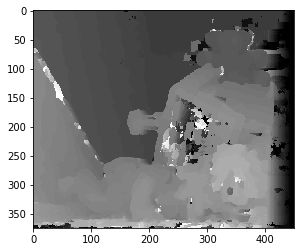

In [7]:
plt.imshow(disparityrl, cmap='gray', vmin=0, vmax=64)

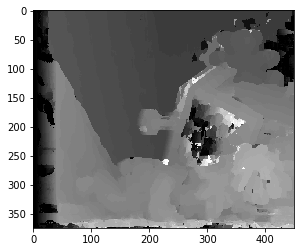

In [8]:
plt.imshow(disparitylr, cmap='gray', vmin=0, vmax=64)

In [119]:
origconl = mpimg.imread("cones/displ.pgm")
origconr = mpimg.imread("cones/dispr.pgm")
origtedl = mpimg.imread("teddy/displ.pgm")
origtedr = mpimg.imread("teddy/dispr.pgm")

In [100]:
dispr = consistency_check(disparityrl,disparitylr, True)
displ = consistency_check(disparitylr,disparityrl, False)
dispr3 = consistency_check(disparityrl3,disparitylr3, True)
displ3 = consistency_check(disparitylr3,disparityrl3, False)
dispr7 = consistency_check(disparityrl7,disparitylr7, True)
displ7 = consistency_check(disparitylr7,disparityrl7, False)
dispr33 = consistency_check(disparityrl33,disparitylr33, True)
displ33 = consistency_check(disparitylr33,disparityrl33, False)
dispconr = consistency_check(dispconesrl9,dispconeslr9, True)
dispconl = consistency_check(dispconeslr9,dispconesrl9, False)

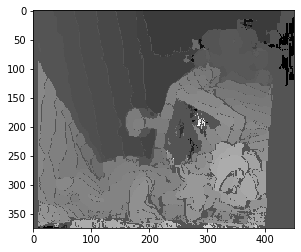

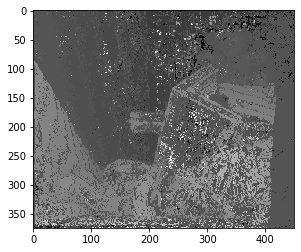

In [153]:
plt.imshow(dispr3, cmap='gray', vmin=0, vmax=64)

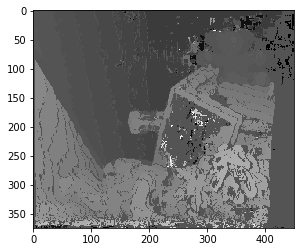

In [154]:
plt.imshow(dispr7, cmap='gray', vmin=0, vmax=64)

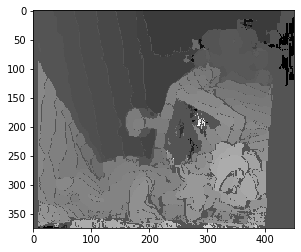

In [156]:
plt.imshow(dispr, cmap='gray', vmin=0, vmax=64)

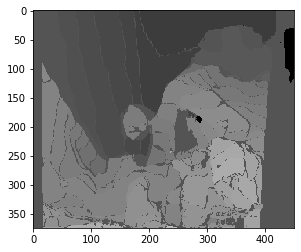

In [155]:
plt.imshow(dispr33, cmap='gray', vmin=0, vmax=64)

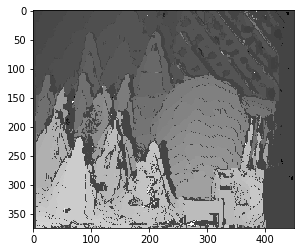

In [157]:
plt.imshow(dispconr, cmap='gray', vmin=0, vmax=64)

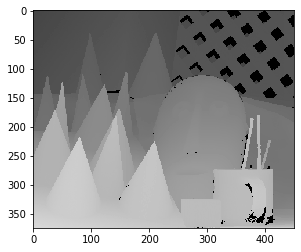

In [147]:
plt.imshow(origconr, cmap='gray', vmin=0, vmax=255)

In [151]:
print("Teddy 3:")
evaluation(origtedl,origtedr,displ3,dispr3,"teddy/teddy3L.png","teddy/teddy3R.png")
print("\n")
print("Teddy 7:")
evaluation(origtedl,origtedr,displ7,dispr7,"teddy/teddy7L.png","teddy/teddy7R.png")
print("\n")
print("Teddy 21:")
evaluation(origtedl,origtedr,displ,dispr,"teddy/teddy21L.png","teddy/teddy21R.png")
print("\n")
print("Teddy 33:")
evaluation(origtedl,origtedr,displ33,dispr33,"teddy/teddy33L.png","teddy/teddy33R.png")
print("\n")
print("Cones 9:")
evaluation(origconl,origconr,dispconl,dispconr,"cones/cones9L.png","cones/cones9R.png")
print("\n")

Teddy 3:
Bad1.0 L: 0.49328761904761903 
Bad1.0 R: 0.5198704761904762
Bad2.0 L: 0.4433066666666667 
Bad2.0 R: 0.46426666666666666 
Bad4.0 L: 0.38160761904761903 
Bad4.0 R: 0.39606857142857144 
RMS L: 9.285278748027515 
RMS R: 9.715693220862049


Teddy 7:
Bad1.0 L: 0.3220342857142857 
Bad1.0 R: 0.3436342857142857
Bad2.0 L: 0.2895542857142857 
Bad2.0 R: 0.3037714285714286 
Bad4.0 L: 0.2582933333333333 
Bad4.0 R: 0.26584380952380954 
RMS L: 8.066468012115104 
RMS R: 8.493718547368093


Teddy 21:
Bad1.0 L: 0.2912152380952381 
Bad1.0 R: 0.30697142857142856
Bad2.0 L: 0.2591085714285714 
Bad2.0 R: 0.26712380952380954 
Bad4.0 L: 0.22072380952380952 
Bad4.0 R: 0.22061714285714285 
RMS L: 7.475089647495556 
RMS R: 7.835985700903358


Teddy 33:
Bad1.0 L: 0.3233371428571429 
Bad1.0 R: 0.3432152380952381
Bad2.0 L: 0.27127619047619045 
Bad2.0 R: 0.280312380952381 
Bad4.0 L: 0.2202895238095238 
Bad4.0 R: 0.22146285714285716 
RMS L: 7.299706028001271 
RMS R: 7.734463967020782


Cones 9:
Bad1.0 L: 0.284

In [79]:
plt.imsave("teddy/teddy17L.png",displ)
plt.imsave("teddy/teddy17R.png",dispr)